# Sistemas Recomendadores

<font size=4>Técnicas Avanzadas de Análisis de Datos</font>

> Daute Rodríguez Rodríguez

## Objetivo

Construir distintos tipos de sistemas recomendadores para analizar, estudiar y comparar sus comportamientos.

## Preparación


In [0]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.exceptions import NotFittedError

### Surprise
from surprise import KNNWithMeans, SVD, SlopeOne, CoClustering
from surprise import Dataset, Reader, AlgoBase, PredictionImpossible
from surprise.model_selection import cross_validate, KFold
from surprise.accuracy import rmse, mae

sns.set()

random_state = 8

## Lectura de datos

En las siguientes celdas de código se cargan los diferentes conjuntos de datos que se utilizarán para comprobar y comparar el rendimiento de los distintos sistemas recomendadores que se presentan a lo largo del notebook. Se realizarán repetidas ejecuciones con conjuntos de datos de **distinto tamaño** (distintas densidades para la matriz de valoraciones) con el propósito de comprobar cómo varía el comportamiento de cada sistema recomendador con distinta cantidad de usuarios e items.


Dado que la cantidad de datos de los que se dispone es sumamente grande, ha resultado necesario reducir la dimensionalidad de los mismos. Los conjuntos de datos que se utilizarán han sido obtenidos al reducir los datos iniciales de una manera específica (con el notebook _DataPreparation.ipynb_), cada uno queda identificado por una cadena con la estructura _-X-Y-Z_ dónde:

* _X_: Cantidad mínima de valoraciones permitidas por usuario
* _Y_: Cantidad máxima de valoraciones permitidas por usuario
* _Z_: Cantidad mínima de valoraciones permitidas por libro

In [0]:
def GetData(suffix='-5-8-10', splits=5):
    ratingsDf = pd.read_csv(f'data/ratings{suffix}.csv', index_col=0, dtype={'user_id': int, 'book_id': int})
    booksDf = pd.read_csv(f'books{suffix}.csv', index_col=0, dtype={'book_id': int})
    authorsDf = pd.read_csv(f'authors{suffix}.csv', index_col=0)
    
    reader = Reader(rating_scale=(0, 5))
    data = Dataset.load_from_df(ratingsDf[['user_id', 'book_id', 'rating']], reader)
    
    kf = KFold(n_splits=splits, random_state=random_state)
    
    return data, kf, ratingsDf, booksDf, authorsDf

In [0]:
datasets = {}
for suffix in ['-5-8-10', '-10-15-10', '-20-25-10']:
    data, kf, ratings, books, authors = GetData(suffix)
    datasets[suffix] = {
        'data': data,
        'kf': kf,
        'ratings': ratings,
        'books': books,
        'authors': authors
    }

En concreto, para los experimentos se usarán los siguientes conjuntos de datos:

* _-5-8-10_:
    * Valoraciones: 75444
    * Usuarios: 13031
    * Libros: 1101
    * Autores: 903
* _-10-15-10_:
    * Valoraciones: 160798
    * Usuarios: 13819
    * Libros: 1955
    * Autores: 1596
* _-20-25-10_:
    * Valoraciones: 200981
    * Usuarios: 9378
    * Libros: 1892
    * Autores: 1407

## Creación de sistemas recomendadores

En esta sección del notebook se crean algunos de los recomendadores colaborativos que ofrece la librería _surprise_ para posteriormente comparar comportamiento.

In [0]:
recommenders = {}

### Recomendador base

Recomendador que para cualquier par usuario-item devuelve la valoración media del conjunto de entrenamiento. Creado con el propósito de comparar los recomendadores que se obtengan posteriormente.

In [0]:
class BaseRecommender(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)
        
    def estimate(self, u, i):
        return self.trainset.global_mean

In [0]:
recommenders['base'] = BaseRecommender()

### Recomendadores Colaborativos

#### KNNWithMeans

Recomendador Item-Item utilizando la medida de similitud del coseno para el cálculo de la similitud entre items. Para el tamaño de la vecindad se optará por el valor por defecto (40).

In [0]:
recommenders['knnWithMeans'] = KNNWithMeans(sim_options={'user_based': False, 'name': 'cosine'})

#### SVD

In [0]:
recommenders['svd'] = SVD(random_state=random_state)

#### SlopeOne

In [0]:
recommenders['slopeOne'] = SlopeOne()

#### CoClustering

In [0]:
recommenders['coClustering'] = CoClustering(random_state=random_state)

#### Evaluación

Por cada conjunto de datos y cada recomendador se aplicará validación cruzada de 5 pliegues, para comparar la calidad de cada recomendador se hallará la métrica _RMSE_ (media y desviación típica del conjunto de valores _RMSE_ obtenidos al utilizar el sistema recomendador sobre cada pliegue del conjunto de datos).

In [0]:
results = {
    'dataset': [],
    'recommender': [],
    'meanRMSE': [],
    'stdRMSE': []
}

for datasetId in datasets:
    dataset = datasets[datasetId]
    for recommenderId in recommenders:
        recommender = recommenders[recommenderId]
        partialResults = cross_validate(recommender, dataset['data'], measures=['rmse'], cv=dataset['kf'], n_jobs=-1)
        results['dataset'].append(datasetId)
        results['recommender'].append(recommenderId)
        results['meanRMSE'].append(round(np.mean(partialResults['test_rmse']), 4))
        results['stdRMSE'].append(round(np.std(partialResults['test_rmse']), 4))

resultsDf = pd.DataFrame.from_dict(results)

Los resultados muestran que el mejor sistema recomendador de entre los obtenidos hasta el momento es el construido con el algoritmo _SVD_ para los 3 conjuntos de datos.

In [0]:
resultsDf

,dataset,recommender,meanRMSE,stdRMSE
0,-5-8-10,base,1.5059,0.0150
1,-5-8-10,knnWithMeans,1.4589,0.0078
2,-5-8-10,svd,1.3883,0.0111
3,-5-8-10,slopeOne,1.5042,0.0119
4,-5-8-10,coClustering,1.4725,0.0093
5,-10-15-10,base,1.3646,0.0088
6,-10-15-10,knnWithMeans,1.2716,0.0065
7,-10-15-10,svd,1.2467,0.0088
8,-10-15-10,slopeOne,1.2993,0.0061
9,-10-15-10,coClustering,1.3045,0.0079


## Recomendador basado en contenido

#### Obtención de las características de los libros

Funciones auxiliares utilizadas para extraer los posibles géneros de la totalidad de libros disponibles en el conjunto de datos y para obtener las características de un libro específico.

In [0]:
def GetBooksGenres(books):
    genres = set()
    for item in books['genres'].values:
        genres.update(item.split(','))
    genres = list(genres)
    genres.sort()
    return genres

def GetBookFeatures(genres, bookInfo, authors):
    bookGenres = bookInfo['genres'].split(',')
    genreVector = np.zeros(len(genres))
    for i in range(len(genres)):
        if genres[i] in bookGenres:
            genreVector[i] = 1.0
    authorsIds =  [int(authorId) for authorId in bookInfo['authors'].split(',')]
    authors = authors.loc[authors['author_id'].isin(authorsIds), 'name'].values
    return ({
        'genreVector': genreVector,
        'genres': bookGenres,
        'authors': authors
    })

#### Obtención de las preferencias de usuario

Función auxiliar que devuelve información sobre un usuario. Entre la información que retorna esta función se encuentra:

* Vector de preferencias de géneros de los libros
* Valoración media de cada autor del que ha leído un libro
* Valor medio del total de sus valoraciones

In [0]:
def GetUserBooksPreferences(genres, userRatings, booksFeatures):
    genresCount = {genre: 0 for genre in genres}
    authorsCount = {}
    preferences = {}
    preferences['genres'] = {}
    preferences['authors'] = {}
    meanRating = userRatings['rating'].mean()
    
    for i in range(len(userRatings)):
        rating = userRatings.loc[i, 'rating']
        book_id = userRatings.loc[i, 'book_id']
        bookGenres = booksFeatures[book_id]['genres']
        bookAuthors = booksFeatures[book_id]['authors']
        for genre in bookGenres:
            genresCount[genre] += 1
            preferences['genres'][genre] = preferences['genres'].get(genre, 0) + rating
        for author in bookAuthors:
            authorsCount[author] = authorsCount.get(author, 0) + 1
            preferences['authors'][author] = preferences['authors'].get(author, 0) + rating
    
    for key in genresCount.keys():
        if key in preferences['genres']:
            preferences['genres'][key] /= genresCount[key]
        else:
            preferences['genres'][key] = meanRating
    
    for author in authorsCount.keys():
        preferences['authors'][author] /= authorsCount[author]
    
    preferences['genres'] = np.array([preferences['genres'][key] for key in sorted(list(preferences['genres'].keys()))])
    preferences['meanRating'] = meanRating
    
    return preferences

#### Clase que representa el sistema recomendador basado en contenido

La siguiente clase representa un sistema recomendador basado en contenido. Este recomendador estima la valoración que hará un usuario sobre un libro a partir de las preferencias del usuario y las características propias del libro. En concreto, al realizar la estimación se tienen en cuenta dos elementos:

* Autor/es del libro
* Género/s del libro

Ambos tienen un peso asociado (_authorsWeight_ y _genresWeight_ respectivamente) al realizar la estimación. La suma de estos parámetros ha de ser igual a una unidad.

In [0]:
class ContentBasedRecommenderSystem(AlgoBase):
    
    def __init__(self, booksDf, authorsDf, authorsWeight=0.5, genresWeight=0.5):
        AlgoBase.__init__(self)
        
        self.books = booksDf
        self.authors = authorsDf
        self.booksGenres = []
        self.booksFeatures = {}
        self.usersPreferences = {}
        self.authorsWeight = authorsWeight
        self.genresWeight = genresWeight
    
    def estimate(self, user_id, book_id):
        
        if not self.trainset.knows_item(book_id):
            raise PredictionImpossible('Unknown book')
        
        if not self.trainset.knows_user(user_id):
            return self.trainset.global_mean
        
        bookFeatures = self.booksFeatures[book_id]
        userPreferences = self.usersPreferences[user_id]
        
        genresValue = np.dot(userPreferences['genres'], bookFeatures['genreVector']) / len(bookFeatures['genres'])
        authorsValue = 0
        for author in bookFeatures['authors']:
            authorsValue += userPreferences['authors'][author] if author in userPreferences['authors'] else self.trainset.global_mean
        authorsValue /= len(bookFeatures['authors'])
        
        return genresValue * self.genresWeight + authorsValue * self.authorsWeight
    
    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        
        self.booksGenres = GetBooksGenres(self.books)
        
        for index, row in self.books.iterrows():
            innerBookId = trainset.to_inner_iid(row['book_id'])
            self.booksFeatures[innerBookId] = GetBookFeatures(self.booksGenres, row, self.authors)
        
        for user in trainset.all_users():
            aux = {'user_id': [], 'book_id': [], 'rating': []}
            for rating in trainset.ur[user]:
                aux['user_id'].append(user)
                aux['book_id'].append(rating[0])
                aux['rating'].append(rating[1])
            userRatings = pd.DataFrame.from_dict(aux)
            self.usersPreferences[user] = GetUserBooksPreferences(self.booksGenres, userRatings, self.booksFeatures)
        
        return self

In [0]:
recommenders['cbrs'] = ContentBasedRecommenderSystem([], [])

#### Optimización de los parámetros _authorsWeight_ y _genresWeight_

In [0]:
cbrsResults = {
    'dataset': [],
    'authorsWeight': [],
    'genresWeight': [],
    'RMSE': []
}

weights = [(0.0, 1.0), (0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1), (1.0, 0.0)]

for datasetId in datasets:
    dataset = datasets[datasetId]
    recommenders['cbrs'].books = dataset['books']
    recommenders['cbrs'].authors = dataset['authors']
    
    for trainset, testset in dataset['kf'].split(dataset['data']):
        recommenders['cbrs'].fit(trainset)
        for authorsWeight, genresWeight in weights:
            recommenders['cbrs'].authorsWeight = authorsWeight
            recommenders['cbrs'].genresWeight = genresWeight
            predictions = recommenders['cbrs'].test(testset)
            cbrsResults['dataset'].append(datasetId)
            cbrsResults['authorsWeight'].append(authorsWeight)
            cbrsResults['genresWeight'].append(genresWeight)
            cbrsResults['RMSE'].append(round(rmse(predictions, verbose=False), 4))

cbrsResultsDf = pd.DataFrame.from_dict(cbrsResults)

La siguiente celda de código muestra que para los dataset _-10-15-10_ y _-20-25-10_ los valores óptimos para _authorsWeight_ y _genresWeight_ son 0.4 y 0.6 respectivamente. Para el conjunto de datos de menor tamaño, los valores óptimos para los pesos son similares (0.5 y 0.5). Por conveniencia, se usaran los valores óptimos para los conjuntos de datos de mayor tamaño, es decir, 0.4 para _authorsWeight_ y 0.6 para _genresWeight_.

In [0]:
grp = cbrsResultsDf.groupby(['dataset', 'authorsWeight', 'genresWeight'], as_index=False).mean()

In [0]:
grp

,dataset,authorsWeight,genresWeight,RMSE
0,-10-15-10,0.0,1.0,1.29006
1,-10-15-10,0.1,0.9,1.27280
2,-10-15-10,0.2,0.8,1.26050
3,-10-15-10,0.3,0.7,1.25334
4,-10-15-10,0.4,0.6,1.25144
5,-10-15-10,0.5,0.5,1.25474
6,-10-15-10,0.6,0.4,1.26326
7,-10-15-10,0.7,0.3,1.27684
8,-10-15-10,0.8,0.2,1.29540
9,-10-15-10,0.9,0.1,1.31870


In [0]:
for datasetId in datasets:
    current = grp[grp['dataset'] == datasetId]
    print(f'Optimal weights for {datasetId} dataset')
    print(current.loc[current['RMSE'].idxmin()][['authorsWeight', 'genresWeight']].values)

Optimal weights for -5-8-10 dataset
[0.5 0.5]
Optimal weights for -10-15-10 dataset
[0.4 0.6]
Optimal weights for -20-25-10 dataset
[0.4 0.6]


Tras encontrar el valor óptimo de los pesos asociados a los elementos que se tienen en cuenta en el sistema recomendador basado en contenido, se han de almacenar los resultados asociados a la predicción que dicho recomendador realiza sobre cada conjunto de datos:

In [0]:
recommenders['cbrs'].authorsWeight = 0.4
recommenders['cbrs'].genresWeight = 0.6

for datasetId in datasets:
    dataset = datasets[datasetId]
    recommenders['cbrs'] = ContentBasedRecommenderSystem(dataset['books'], dataset['authors'])
    recommenders['cbrs'].books = dataset['books']
    recommenders['cbrs'].authors = dataset['authors']
    
    partialResults = cross_validate(recommenders['cbrs'], dataset['data'], measures=['rmse'], cv=dataset['kf'], n_jobs=-1)
    newRow = pd.Series([datasetId, 'cbrs', round(np.mean(partialResults['test_rmse']), 4), round(np.std(partialResults['test_rmse']), 4)], index=['dataset', 'recommender', 'meanRMSE', 'stdRMSE'])
    resultsDf = resultsDf.append(newRow, ignore_index=True)

## Recomendador híbrido paralelizado ponderado

Por último, se creará un recomendador híbrido paralelizado ponderado. Internamente hará uso del mejor recomendador colaborativo de entre los estudiados (algoritmo svd) y del recomendador basado en contenido.

In [0]:
class HybridRecommenderSystem(AlgoBase):
    def __init__(self, svd, cbrs, svdWeight=0.5, cbrsWeight=0.5):
        AlgoBase.__init__(self)
        self.svd = svd
        self.cbrs = cbrs
        self.svdWeight = svdWeight
        self.cbrsWeight = cbrsWeight
        
        self.cbrs.genresWeight = 0.6
        self.cbrs.authorsWeight = 0.4

    
    def estimate(self, user_id, book_id):
        svdValue = self.svd.estimate(user_id, book_id)
        cbrsValue = self.cbrs.estimate(user_id, book_id)
        return svdValue * self.svdWeight + cbrsValue * self.cbrsWeight
    
    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        self.svd.fit(trainset)
        self.cbrs.fit(trainset)
        return self

#### Optimización de los parámetros _svdWeight_ y _cbrsWeight_

In [0]:
recommenders['hybrid'] = HybridRecommenderSystem(recommenders['svd'], recommenders['cbrs'])

hybridResults = {
    'dataset': [],
    'svdWeight': [],
    'cbrsWeight': [],
    'RMSE': []
}

weights = [(0.0, 1.0), (0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1), (1.0, 0.0)]

for datasetId in datasets:
    dataset = datasets[datasetId]
    recommenders['hybrid'].cbrs.books = dataset['books']
    recommenders['hybrid'].cbrs.authors = dataset['authors']
    
    for trainset, testset in dataset['kf'].split(dataset['data']):
        recommenders['hybrid'].fit(trainset)
        for svdWeight, cbrsWeight in weights:
            recommenders['hybrid'].svdWeight = svdWeight
            recommenders['hybrid'].cbrsWeight = cbrsWeight
            predictions = recommenders['hybrid'].test(testset)
            hybridResults['dataset'].append(datasetId)
            hybridResults['svdWeight'].append(svdWeight)
            hybridResults['cbrsWeight'].append(cbrsWeight)
            hybridResults['RMSE'].append(round(rmse(predictions, verbose=False), 4))

hybridResultsDf = pd.DataFrame.from_dict(hybridResults)

In [0]:
grp = hybridResultsDf.groupby(['dataset', 'svdWeight', 'cbrsWeight'], as_index=False).mean()

In [0]:
grp

,dataset,svdWeight,cbrsWeight,RMSE
0,-10-15-10,0.0,1.0,1.25144
1,-10-15-10,0.1,0.9,1.24228
2,-10-15-10,0.2,0.8,1.23506
3,-10-15-10,0.3,0.7,1.22970
4,-10-15-10,0.4,0.6,1.22634
5,-10-15-10,0.5,0.5,1.22490
6,-10-15-10,0.6,0.4,1.22544
7,-10-15-10,0.7,0.3,1.22794
8,-10-15-10,0.8,0.2,1.23234
9,-10-15-10,0.9,0.1,1.23862


La siguiente celda de código muestra que para los dataset _-10-15-10_ y _-5-8-10_ los valores óptimos para _svdWeight_ y _cbrsWeight_ son 0.5 y 0.5 respectivamente. Para el conjunto de datos de mayor tamaño, los valores óptimos para los pesos son similares (0.6 y 0.4). Por conveniencia, se usaran los valores 0.5 para _svdWeight_ y 0.5 para _cbrsWeight_, es decir, se realizará una media entre las predicciones que realicen los sistemas recomendadores basado en contenido y colaborativo.

In [0]:
for datasetId in datasets:
    current = grp[grp['dataset'] == datasetId]
    print(f'Optimal weights for {datasetId} dataset')
    print(current.loc[current['RMSE'].idxmin()][['svdWeight', 'cbrsWeight']].values)

Optimal weights for -5-8-10 dataset
[0.5 0.5]
Optimal weights for -10-15-10 dataset
[0.5 0.5]
Optimal weights for -20-25-10 dataset
[0.6 0.4]


A continuación se almacenan los resultados obtenidos para los valores óptimos de los pesos con el propósito de llevar a cabo una comparación final entre todos los sistemas recomendadores que se han propuesto.

In [0]:
recommenders['hybrid'].svdWeight = 0.5
recommenders['hybrid'].cbrsWeight = 0.5

for datasetId in datasets:
    dataset = datasets[datasetId]
    recommenders['hybrid'].cbrs.books = dataset['books']
    recommenders['hybrid'].cbrs.authors = dataset['authors']
    
    partialResults = cross_validate(recommenders['hybrid'], dataset['data'], measures=['rmse'], cv=dataset['kf'], n_jobs=-1)
    newRow = pd.Series([datasetId, 'hybrid', round(np.mean(partialResults['test_rmse']), 4), round(np.std(partialResults['test_rmse']), 4)], index=['dataset', 'recommender', 'meanRMSE', 'stdRMSE'])
    resultsDf = resultsDf.append(newRow, ignore_index=True)

## Comparativa

En esta sección del notebook se llevará a cabo una comparación del comportamiento de los sistemas recomendadores construidos.

In [0]:
resultsDf

,dataset,recommender,meanRMSE,stdRMSE
0,-5-8-10,base,1.5059,0.0150
1,-5-8-10,knnWithMeans,1.4589,0.0078
2,-5-8-10,svd,1.3883,0.0111
3,-5-8-10,slopeOne,1.5042,0.0119
4,-5-8-10,coClustering,1.4725,0.0093
5,-10-15-10,base,1.3646,0.0088
6,-10-15-10,knnWithMeans,1.2716,0.0065
7,-10-15-10,svd,1.2467,0.0088
8,-10-15-10,slopeOne,1.2993,0.0061
9,-10-15-10,coClustering,1.3045,0.0079


Atendiendo a la media de los valores de la columna meanRMSE por cada conjunto de datos es posible comprobar cómo la densidad de la matriz de valoraciones determina el comportamiento de los sistemas recomendadores de forma general. A mayor densidad el valor de la métrica RMSE disminuye, por lo que los sistemas recomendadores se comportan mejor.

In [0]:
resultsDf.groupby(['dataset']).mean()[['meanRMSE']]

,meanRMSE
dataset,
-10-15-10,1.280900
-20-25-10,1.191657
-5-8-10,1.439157


Atendiendo a las siguientes gráficas, el mejor sistema recomendador para los 3 conjuntos de datos ha sido el híbrido. Tal y cómo cabría esperar, el recomendador base ha sido el que peor comportamiento ha demostrado para los conjuntos de datos estudiados. También cabe destacar la segunda posición del sistema construido con el algoritmo SVD. El sistema recomendador basado en contenido ha conseguido el tercer puesto para los conjuntos de datos de menor tamaño, en el caso del conjunto de datos _20-25-10_ el tercer puesto queda ocupado por el sistema recomendador Item-Item basado en KNN con las medias y el basado en contenido ocupa el cuarto lugar.

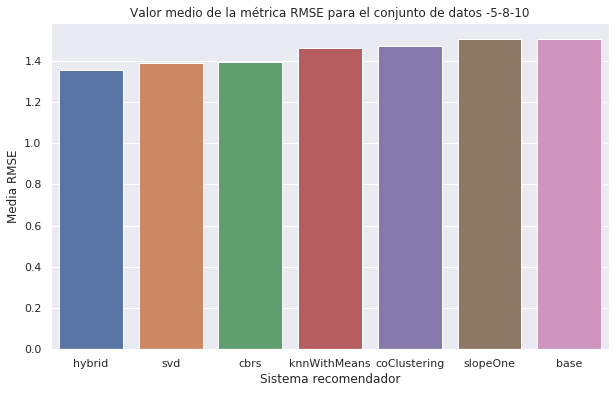

In [0]:
fig, ax = plt.subplots(figsize=(10, 6))

data = resultsDf[resultsDf['dataset'] == '-5-8-10'].sort_values(['meanRMSE']).reset_index(drop=True)
ax = sns.barplot(x="recommender", y='meanRMSE', data=data, ax=ax)
ax.set_title('Valor medio de la métrica RMSE para el conjunto de datos -5-8-10')
ax.set(xlabel='Sistema recomendador', ylabel='Media RMSE')
plt.savefig('comparison-5-8-10.png')

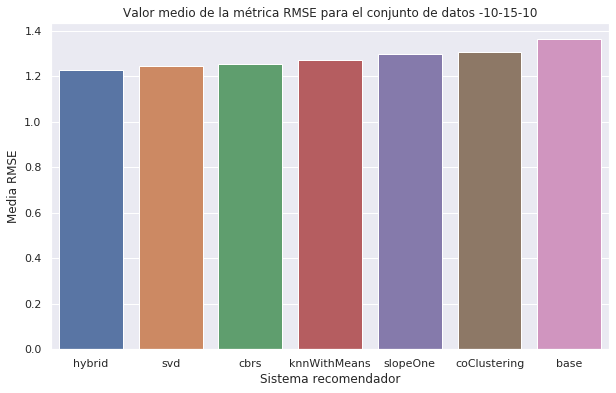

In [0]:
fig, ax = plt.subplots(figsize=(10, 6))

data = resultsDf[resultsDf['dataset'] == '-10-15-10'].sort_values(['meanRMSE']).reset_index(drop=True)
ax = sns.barplot(x="recommender", y='meanRMSE', data=data, ax=ax)
ax.set_title('Valor medio de la métrica RMSE para el conjunto de datos -10-15-10')
ax.set(xlabel='Sistema recomendador', ylabel='Media RMSE')
plt.savefig('comparison-10-15-10.png')

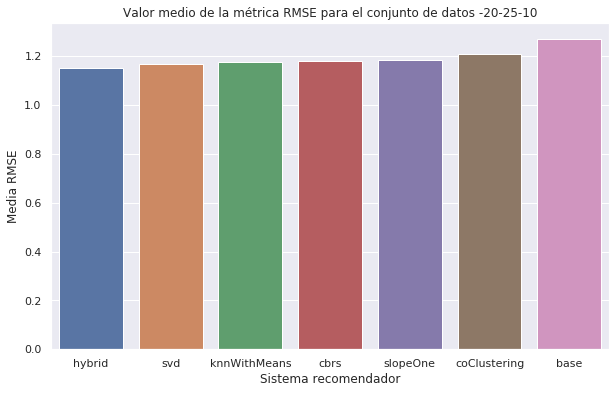

In [0]:
fig, ax = plt.subplots(figsize=(10, 6))

data = resultsDf[resultsDf['dataset'] == '-20-25-10'].sort_values(['meanRMSE']).reset_index(drop=True)
ax = sns.barplot(x="recommender", y='meanRMSE', data=data, ax=ax)
ax.set_title('Valor medio de la métrica RMSE para el conjunto de datos -20-25-10')
ax.set(xlabel='Sistema recomendador', ylabel='Media RMSE')
plt.savefig('comparison-20-25-10.png')